# Phase curve parameterization 

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.table import vstack
from scipy.optimize import leastsq, minimize

from scipy.stats import chisquare
import scienceplots
#from photometric_models import HG, HG12, HG1G2
from db import query
#import emcee
#import corner
from tqdm import tqdm

plt.style.use('science')

filters = ['g', 'r', 'i', 'z']
filter_colors = {'g': '#008060', 'r': '#ff4000', 'i': '#850000', 'z': '#6600cc'}
linestyles = {'g': "--", "r":"-.", "i":":", "z":"-"}
regions = {
    "NEO": "q <= 1.3",
    "Main Belt": "(mpc.e <1) and (mpc.q/(1-mpc.e) >= 1.6) and (mpc.q/(1-mpc.e) <= 4.2 and mpc.q>=1.3)",
    "Jupiter Trojans": "(mpc.q/(1-mpc.e) >= 5.05) and (mpc.q/(1-mpc.e) <= 5.35)" #5.05 and 5.35 AU
}

attribs = ['Chi2', 'G12', 'G12Err', 'H', 'HErr', 'Ndata']

In [2]:
def reduced_mag(mag, heliocentricDist, topocentricDist):
    return mag - 5.0*np.log10(heliocentricDist * topocentricDist)

In [4]:
for region, condition in regions.items():
    stmt = f'''
        select distinct sss.ssObjectId
        from dp03_catalogs_10yr.SSSource as sss
        join dp03_catalogs_10yr.MPCORB as mpc on mpc.SSObjectId = sss.SSObjectId
        where {condition}
        '''

    resp = query(stmt)
    ids_ = resp.to_table().to_pandas()
    ids_.to_csv(f"./IDS/{region}_ids.csv", index=False)

In [43]:
# NEOs

#stream in batches of 10,000
neo_ids = list(pd.read_csv("./IDS/NEO_ids.csv", index_col=False)["ssObjectId"])
delta = 10000
table = None

for i in tqdm(range(np.floor(len(neo_ids)/delta).astype(int))):        
    stmt = f'''
        select sss.ssObjectId,
        band,
        count(phaseAngle), 
        min(phaseAngle) as minPhase, 
        max(phaseAngle) as maxPhase, 
        (max(phaseAngle) - min(phaseAngle))/count(sss.ssObjectId) as phaseDensity, 
        SUM(CASE WHEN phaseAngle < 2 THEN 1 ELSE 0 END) AS oppCOV, 
        SUM(CASE WHEN phaseAngle > 2 AND phaseAngle < 15 THEN 1 ELSE 0 END) AS modCOV, 
        SUM(CASE WHEN phaseAngle > 15 THEN 1 ELSE 0 END) AS highCOV,
        AVG(mag) as avgMag,
        STDDEV(mag) as magSTD,
        AVG(magErr) as avgMagErr,
        STDDEV(magErr) as MagErrSTD
        from dp03_catalogs_10yr.SSSource as sss
        left join dp03_catalogs_10yr.DiaSource as dia on sss.diaSourceId = dia.diaSourceId
        where sss.ssObjectId in {tuple(neo_ids[i*delta:(i+1)*delta])}
        group by sss.ssObjectId, band
        '''
    
    # mag, magErr, phaseAngle, band, heliocentricDist, topocentricDist, midPointMjdTai
    resp = query(stmt)
    if not table:
        table = resp.to_table()
    else:
        table = vstack([table, resp.to_table()])
table.to_pandas().to_csv("./phase_parameters/neo.csv")

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [13:32<00:00, 203.01s/it]


In [50]:
trojan_ids = list(pd.read_csv("./IDS/Jupiter Trojans_ids.csv", index_col=False)["ssObjectId"])
#table = None
delta = 5000
for i in tqdm(range(9,np.floor(len(trojan_ids)/delta).astype(int) + 1)): #tqdm(range(np.floor(len(trojan_ids)/delta).astype(int) + 1)):        
    stmt = f'''
        select sss.ssObjectId,
        band,
        count(phaseAngle), 
        min(phaseAngle) as minPhase, 
        max(phaseAngle) as maxPhase, 
        (max(phaseAngle) - min(phaseAngle))/count(sss.ssObjectId) as phaseDensity, 
        SUM(CASE WHEN phaseAngle < 2 THEN 1 ELSE 0 END) AS oppCOV, 
        SUM(CASE WHEN phaseAngle > 2 AND phaseAngle < 15 THEN 1 ELSE 0 END) AS modCOV, 
        SUM(CASE WHEN phaseAngle > 15 THEN 1 ELSE 0 END) AS highCOV,
        AVG(mag) as avgMag,
        STDDEV(mag) as magSTD,
        AVG(magErr) as avgMagErr,
        STDDEV(magErr) as MagErrSTD
        from dp03_catalogs_10yr.SSSource as sss
        left join dp03_catalogs_10yr.DiaSource as dia on sss.diaSourceId = dia.diaSourceId
        where sss.ssObjectId in {tuple(trojan_ids[i*delta:(i+1)*delta])}
        group by sss.ssObjectId, band
        '''

# mag, magErr, phaseAngle, band, heliocentricDist, topocentricDist, midPointMjdTai
    
    resp = query(stmt)
    if not table:
        table = resp.to_table()
    else:
        table = vstack([table, resp.to_table()])
    table.to_pandas().to_csv("./phase_parameters/jupiter_trojans.csv")

print("Got phase curve params")


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [29:30<00:00, 196.75s/it]


Got phase curve params


DALQueryError: missing required parameter: LANG

In [51]:
photo_table = None
delta = 5000
for i in tqdm(range(np.floor(len(trojan_ids)/delta).astype(int) + 1)):
    stmt = f'''
        select sso.ssObjectId,
        g_Chi2, g_G12, g_G12Err, g_H, g_HErr, g_Ndata, 
        i_Chi2, i_G12, i_G12Err, i_H, i_HErr, i_Ndata, 
        r_Chi2, r_G12, r_G12Err, r_H, r_HErr, r_Ndata, 
        z_Chi2, z_G12, z_G12Err, z_H, z_HErr, z_Ndata
        from dp03_catalogs_10yr.SSObject as sso
        where sso.ssObjectId in {tuple(trojan_ids[i*delta:(i+1)*delta])}
        '''

    resp = query(stmt)
    if not photo_table:
        photo_table = resp.to_table()
    else:
        photo_table = vstack([photo_table, resp.to_table()])
    photo_table.to_pandas().to_csv("./photometric/jupiter_trojans.csv")

100%|██████████| 18/18 [06:46<00:00, 22.57s/it]


In [ ]:
# Look at correlations between the errors for the fitted parameters in the database

In [44]:
df = table.to_pandas()

In [4]:
df = pd.read_csv("./phase_parameters/neo.csv", index_col=False)
df.drop(columns=["ssObjectId"])

,Unnamed: 0,band,count,minPhase,maxPhase,phaseDensity,oppCOV,modCOV,highCOV,avgMag,magSTD,avgMagErr,MagErrSTD
0,0,g,4,16.825115,33.296112,4.117749,0,0,4,22.778250,0.376740,0.077000,0.031443
1,1,i,11,15.710444,49.469246,3.068982,0,0,11,22.177182,1.396005,0.219818,0.501258
2,2,r,12,15.307009,49.445053,2.844837,0,0,12,23.206167,4.047751,0.487333,1.501578
3,3,z,6,21.359219,37.461310,2.683682,0,0,6,23.393333,4.317069,0.538167,1.129170
4,4,g,3,15.760029,16.081547,0.107173,0,0,3,29.653334,3.346718,5.326667,0.366618
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155777,155777,z,11,5.977979,59.565080,4.871555,0,5,6,21.604636,2.267825,0.232364,0.537087
155778,155778,g,2,10.795681,16.813921,3.009120,0,1,1,28.816500,1.007627,3.510500,0.850650
155779,155779,i,15,5.481915,20.515633,1.002248,0,12,3,27.851667,2.597210,3.175133,0.583045
155780,155780,r,11,7.125856,28.669268,1.958492,0,6,5,29.430727,3.260058,3.029818,0.479445


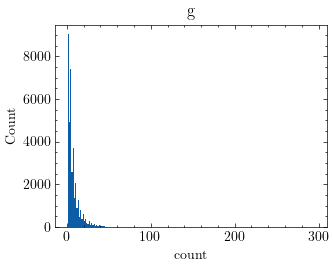

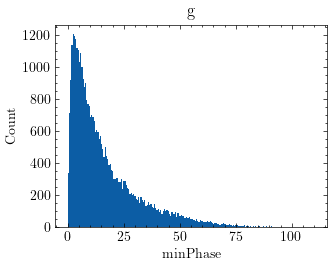

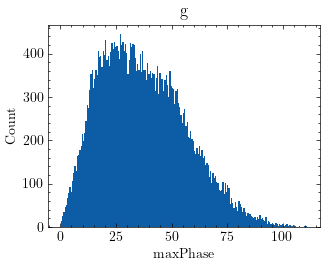

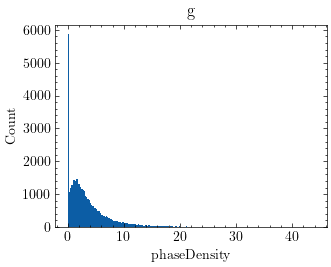

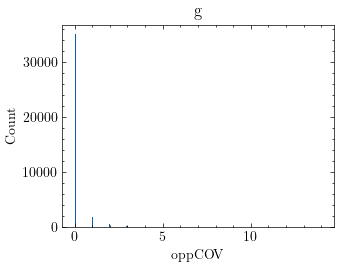

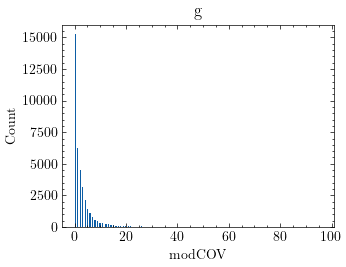

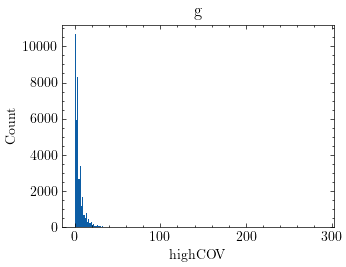

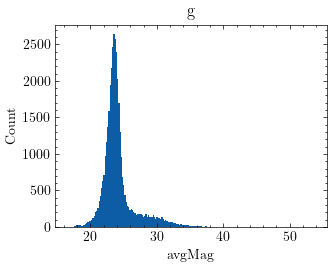

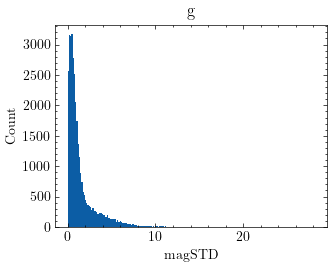

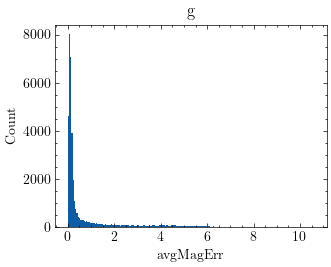

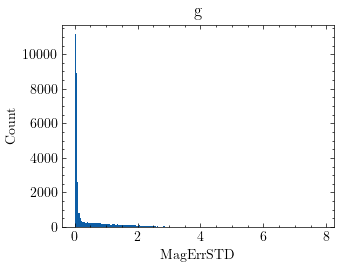

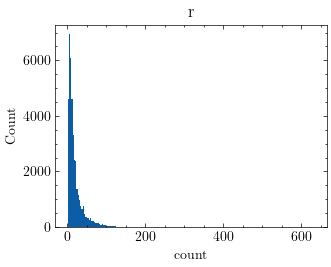

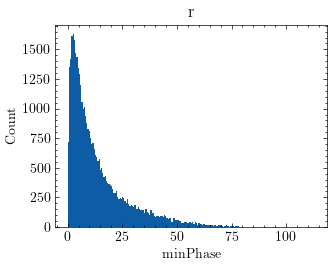

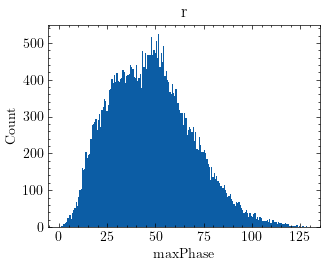

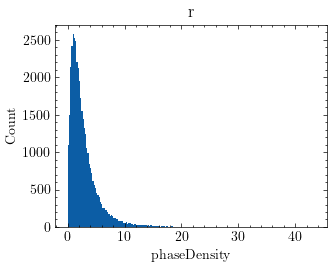

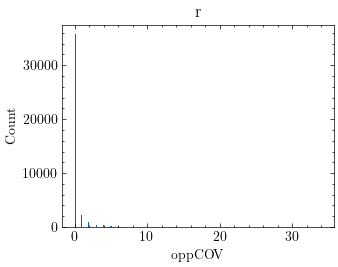

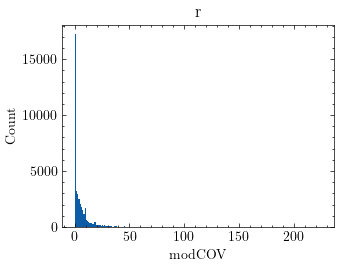

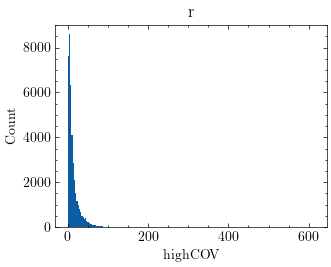

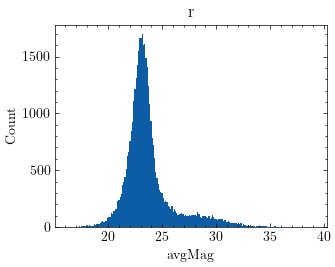

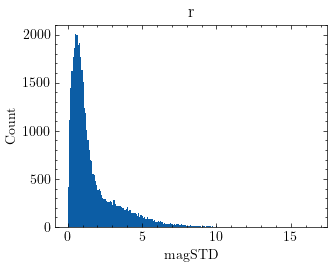

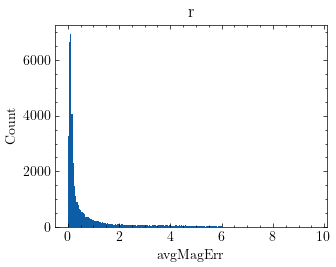

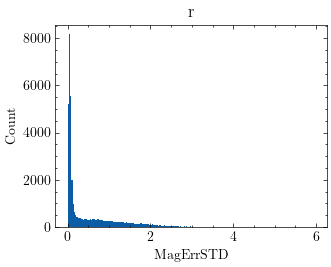

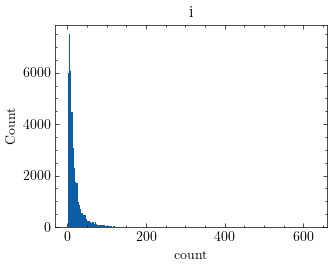

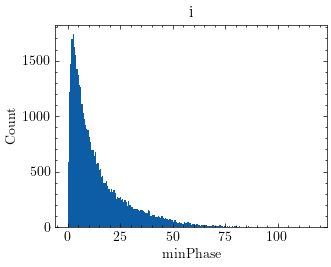

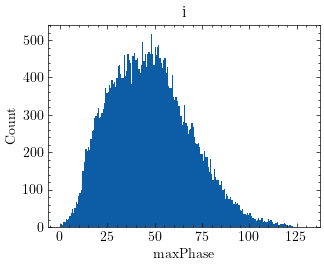

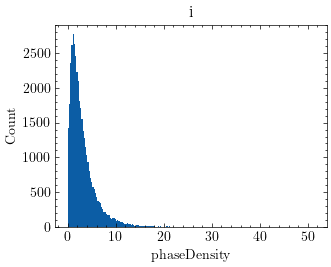

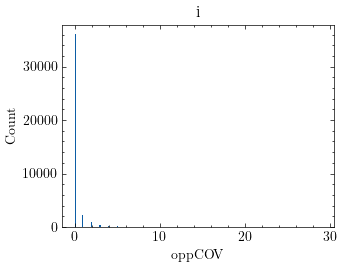

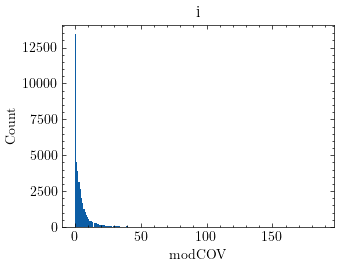

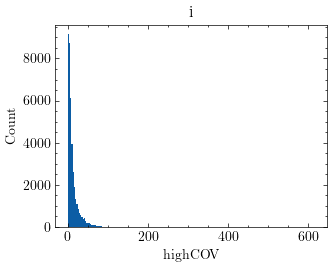

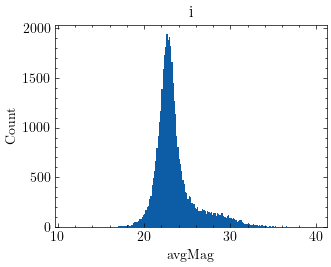

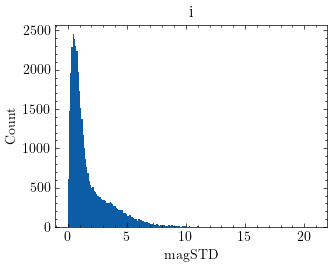

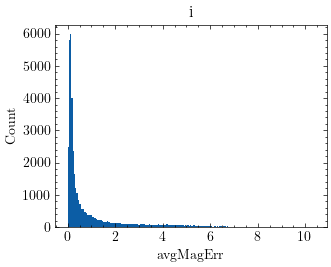

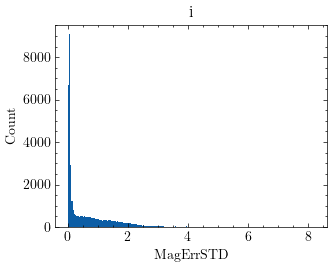

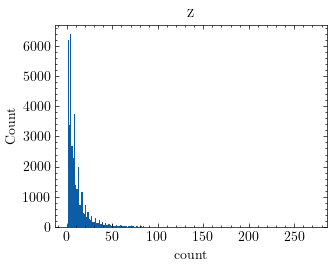

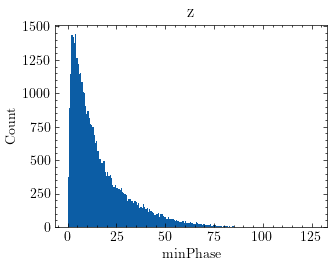

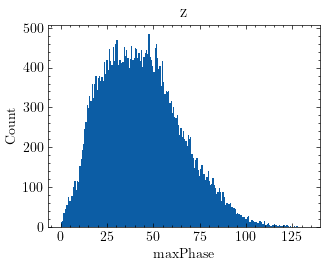

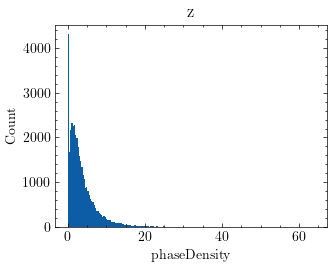

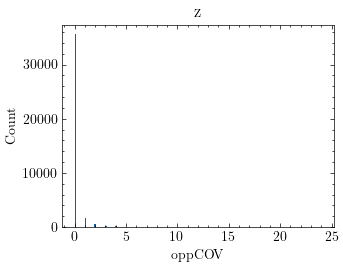

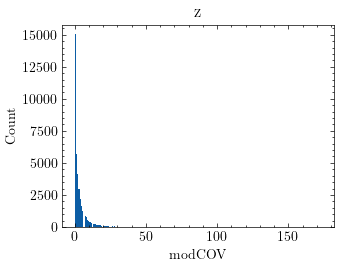

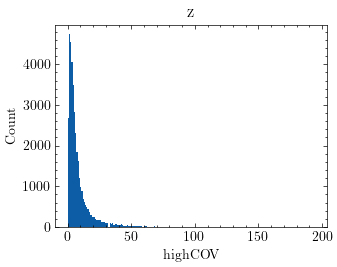

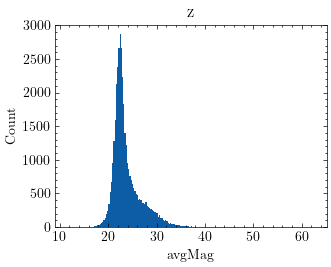

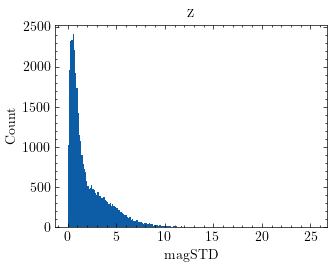

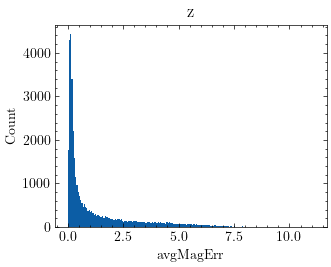

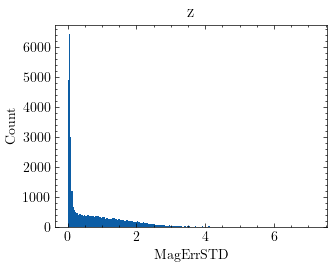

In [47]:
for filt in filters:
    for col in df.drop(columns=["ssObjectId", "Unnamed: 0", "band"]).columns:
        plt.title(filt)
        plt.hist(
            df[df["band"] == filt][col],
            bins=200
        )
        plt.xlabel(f"{col}")
        plt.ylabel("Count")
        plt.show()

In [64]:
# NEOs

#stream in batches of 10,000
neo_ids = list(pd.read_csv("./IDS/NEO_ids.csv", index_col=False)["ssObjectId"])
#delta = 10000
photo_table = None

stmt = f'''
    select sso.ssObjectId,
    g_Chi2, g_G12, g_G12Err, g_H, g_HErr, g_Ndata, 
    i_Chi2, i_G12, i_G12Err, i_H, i_HErr, i_Ndata, 
    r_Chi2, r_G12, r_G12Err, r_H, r_HErr, r_Ndata, 
    z_Chi2, z_G12, z_G12Err, z_H, z_HErr, z_Ndata
    from dp03_catalogs_10yr.SSObject as sso
    where sso.ssObjectId in {tuple(neo_ids)}
    '''

# mag, magErr, phaseAngle, band, heliocentricDist, topocentricDist, midPointMjdTai
resp = query(stmt)
if not photo_table:
    photo_table = resp.to_table()
else:
    photo_table = vstack([photo_table, resp.to_table()])
photo_table.to_pandas().to_csv("./photometric/neo.csv")

OSError: Cannot save file into a non-existent directory: 'photometric'

In [5]:
photo_table.to_pandas().to_csv("./photometric/neo.csv")
df_photo = pd.read_csv("./photometric/neo.csv", index_col=False)
df_merge = pd.merge(left=df, right= df_photo, on="ssObjectId")

In [81]:
'''for filt in filters:
    sns.pairplot(df_merge[df_merge["band"] == filt][['count', 'minPhase', 'maxPhase',
       'phaseDensity', 'oppCOV', 'modCOV', 'highCOV', 'avgMag', 'magSTD',
       'avgMagErr', 'MagErrSTD']+[f"{filt}_{attrib}" for attrib in attribs]])
    break'''

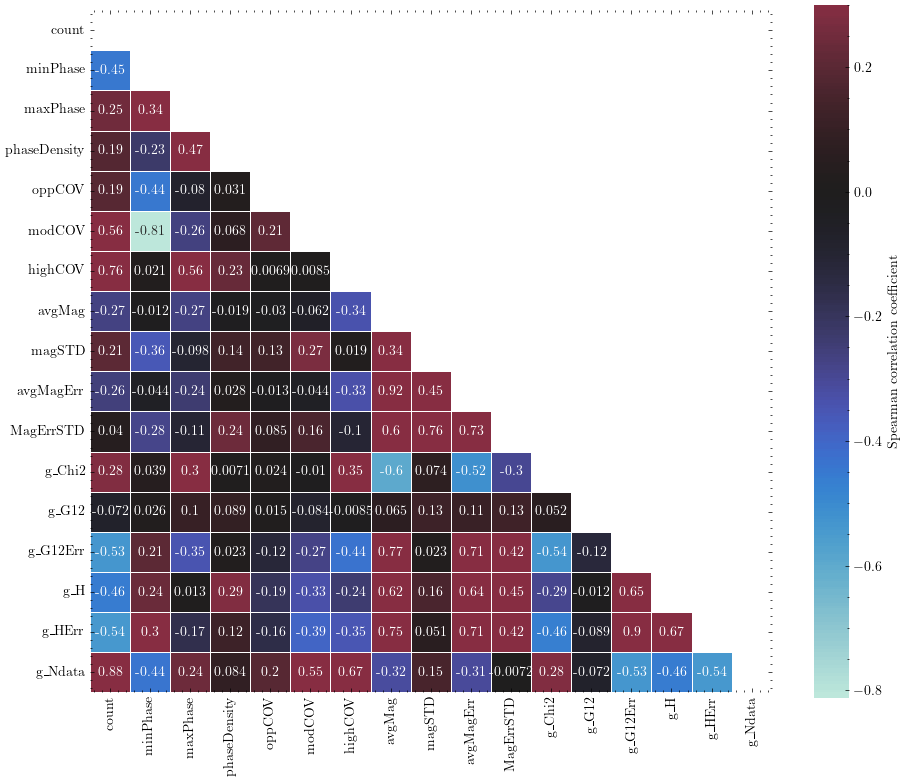

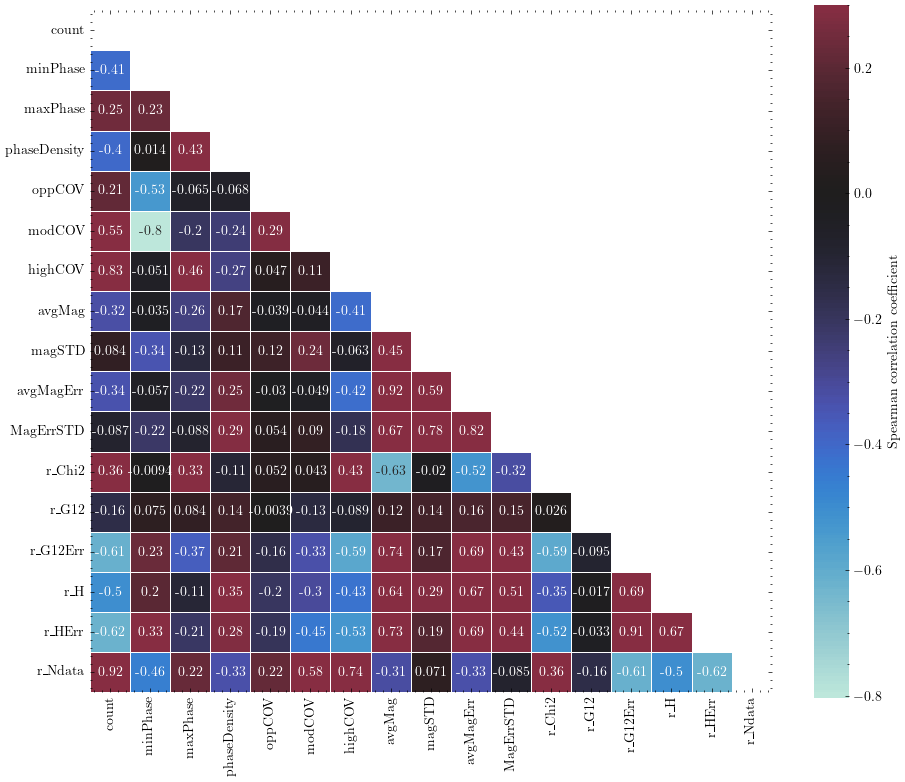

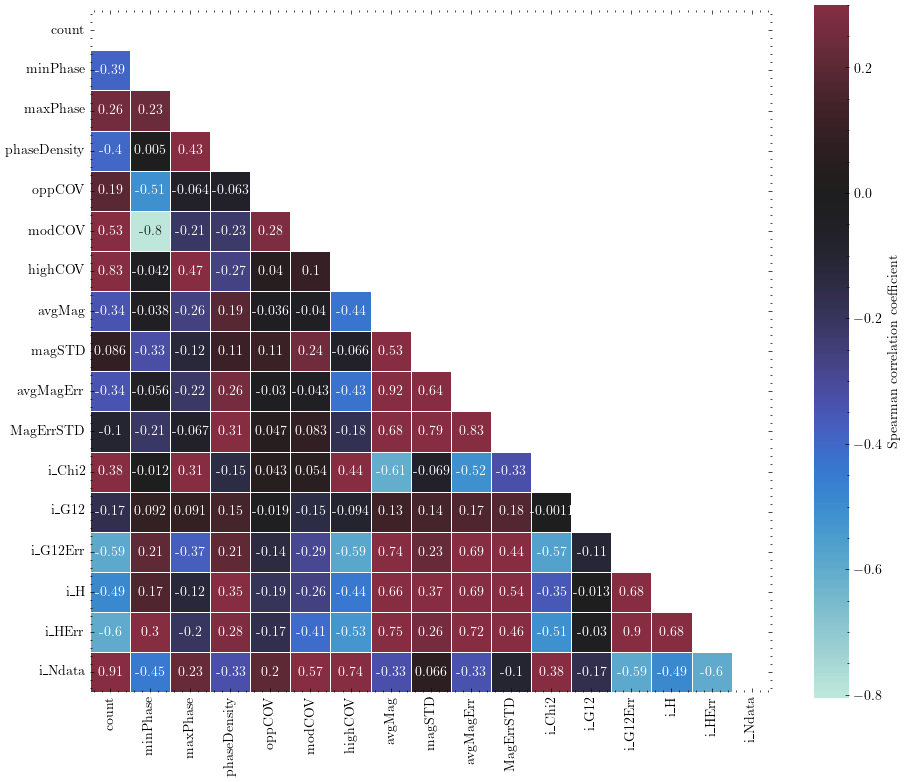

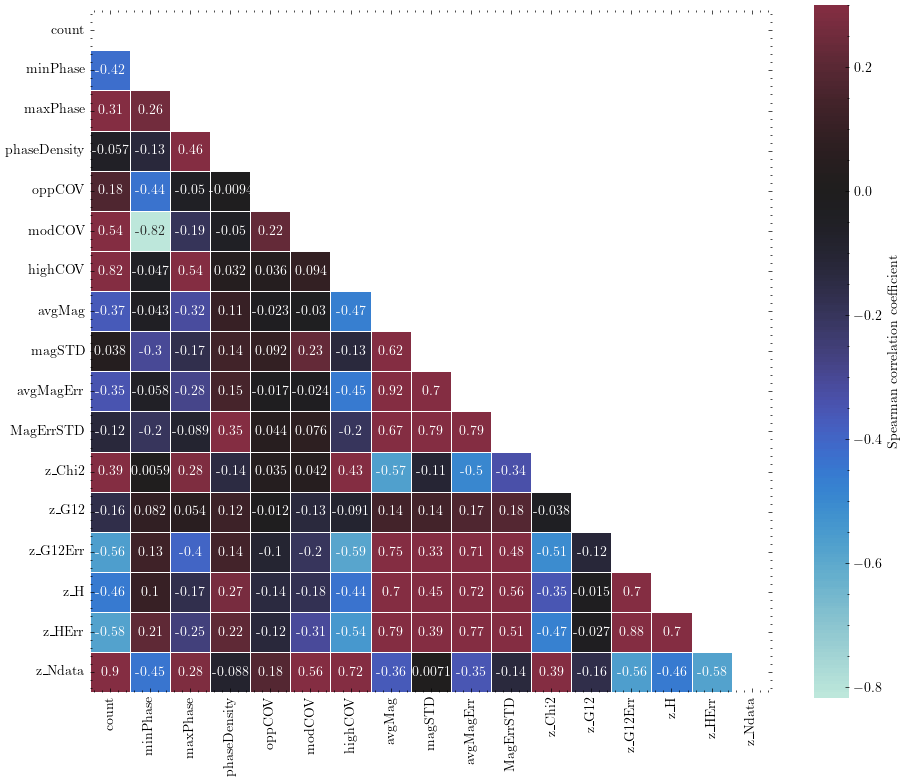

In [19]:
for filt in filters:
    corr = df_merge[df_merge["band"] == filt][['count', 'minPhase', 'maxPhase',
       'phaseDensity', 'oppCOV', 'modCOV', 'highCOV', 'avgMag', 'magSTD',
       'avgMagErr', 'MagErrSTD']+[f"{filt}_{attrib}" for attrib in attribs]].corr(method="spearman")
        
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, vmax=.3, center=0,
                square=True, linewidths=.5,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                annot=True,
                cbar_kws={'label': 'Spearman correlation coefficient'})


Jupiter Trojans

In [55]:
df_j = pd.read_csv("./phase_parameters/jupiter_trojans.csv", index_col=False)
df_photo_j = pd.read_csv("./photometric/jupiter_trojans.csv", index_col=False)
df_merge_j = pd.merge(left=df_j, right= df_photo_j, on="ssObjectId")

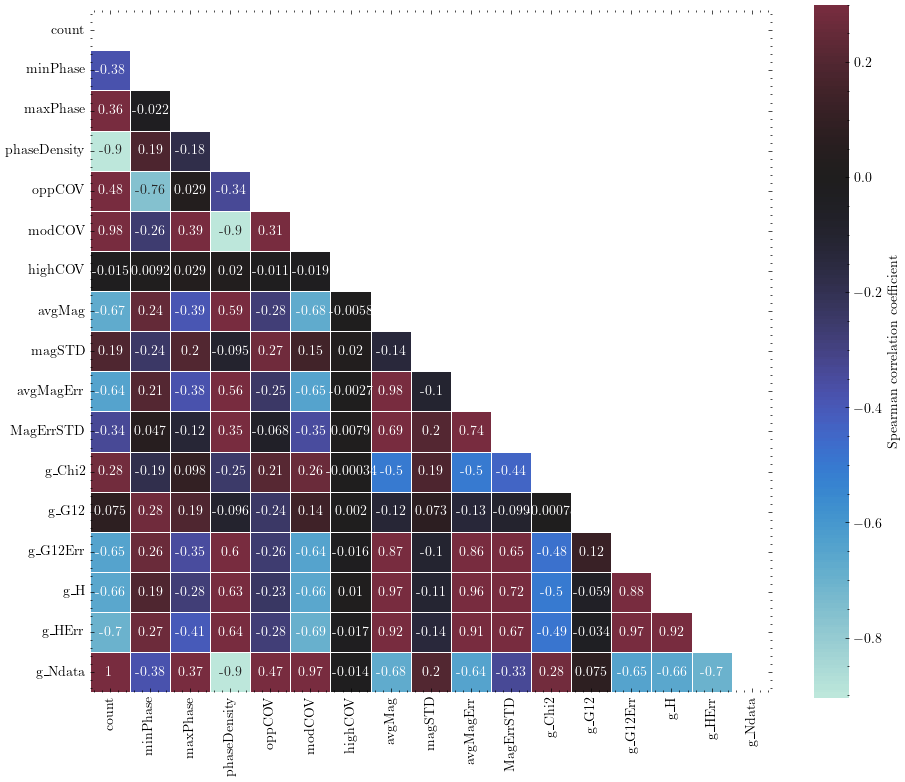

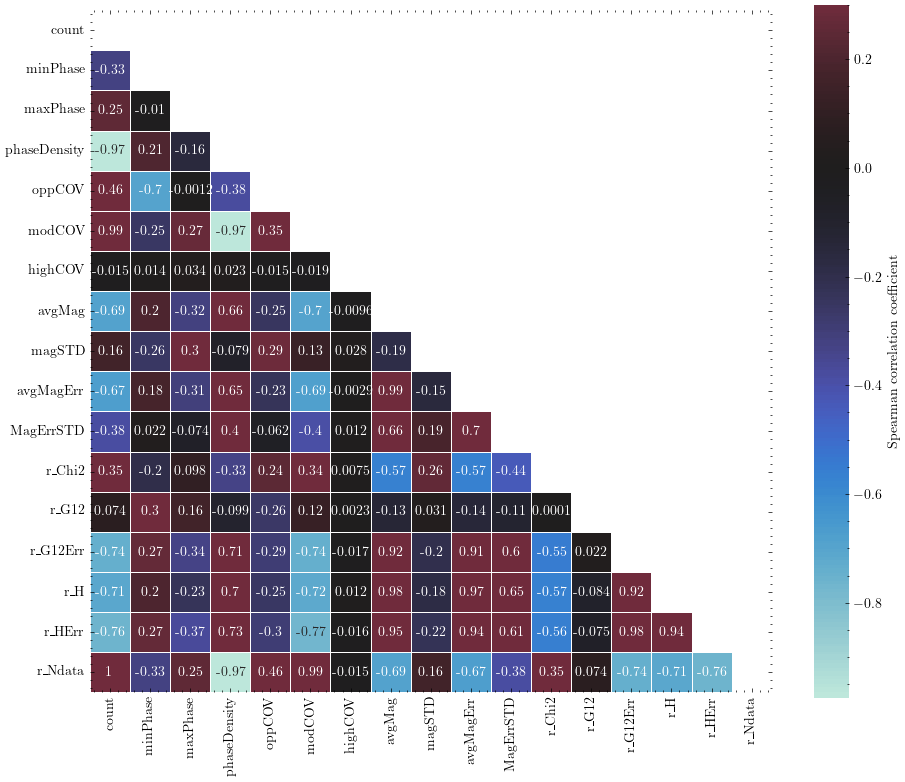

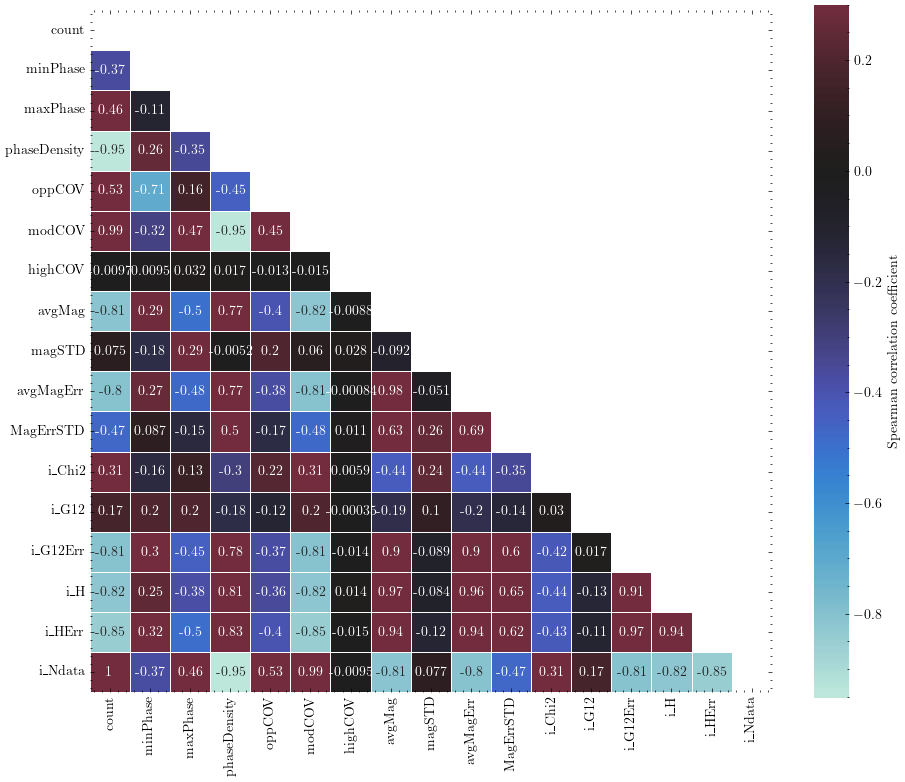

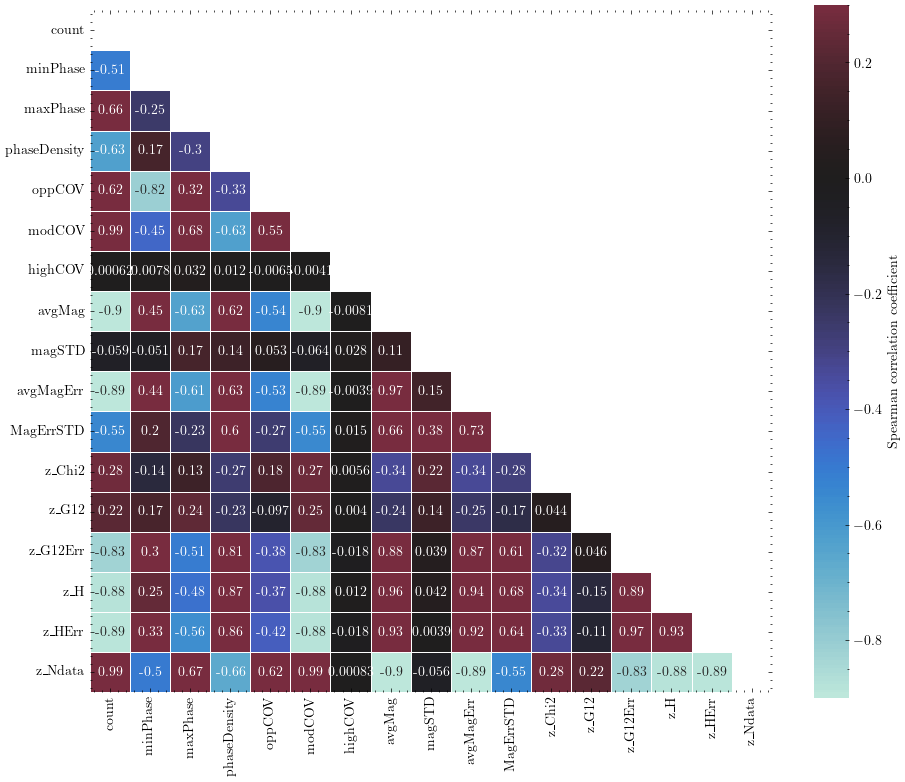

In [56]:
for filt in filters:
    corr = df_merge_j[df_merge_j["band"] == filt][['count', 'minPhase', 'maxPhase',
       'phaseDensity', 'oppCOV', 'modCOV', 'highCOV', 'avgMag', 'magSTD',
       'avgMagErr', 'MagErrSTD']+[f"{filt}_{attrib}" for attrib in attribs]].corr(method="spearman")
        
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, vmax=.3, center=0,
                square=True, linewidths=.5,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                annot=True,
                cbar_kws={'label': 'Spearman correlation coefficient'})

In [96]:
df_merge_j.columns

Index(['Unnamed: 0_x', 'ssObjectId', 'band', 'count', 'minPhase', 'maxPhase',
       'phaseDensity', 'oppCOV', 'modCOV', 'highCOV', 'avgMag', 'magSTD',
       'avgMagErr', 'MagErrSTD', 'Unnamed: 0_y', 'g_Chi2', 'g_G12', 'g_G12Err',
       'g_H', 'g_HErr', 'g_Ndata', 'i_Chi2', 'i_G12', 'i_G12Err', 'i_H',
       'i_HErr', 'i_Ndata', 'r_Chi2', 'r_G12', 'r_G12Err', 'r_H', 'r_HErr',
       'r_Ndata', 'z_Chi2', 'z_G12', 'z_G12Err', 'z_H', 'z_HErr', 'z_Ndata'],
      dtype='object')

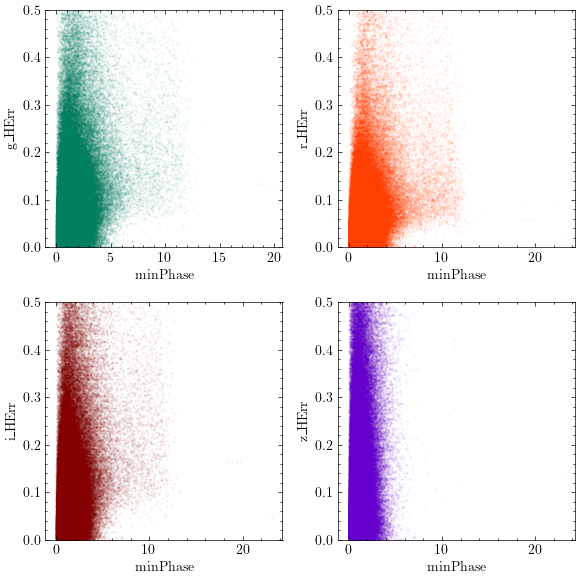

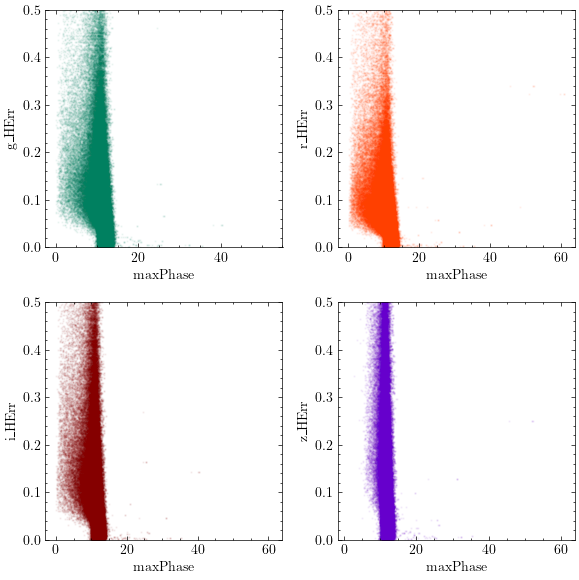

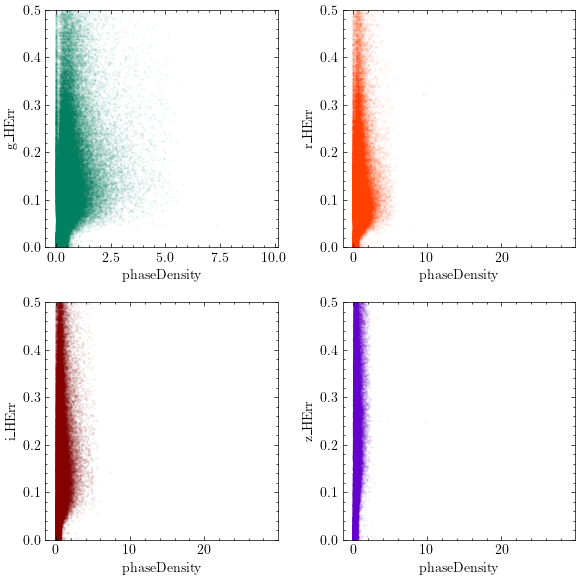

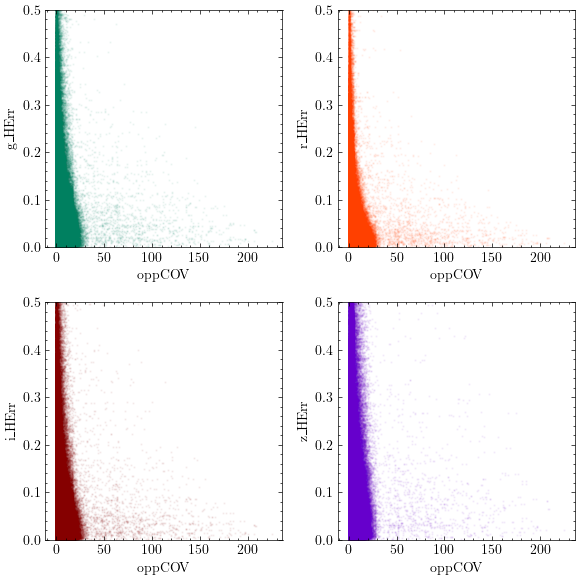

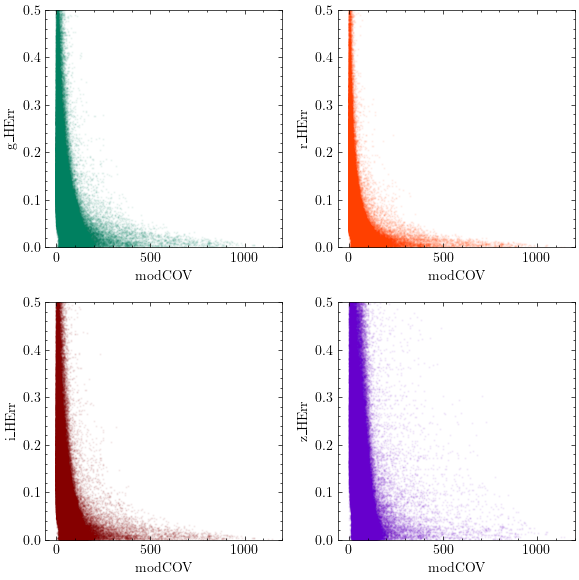

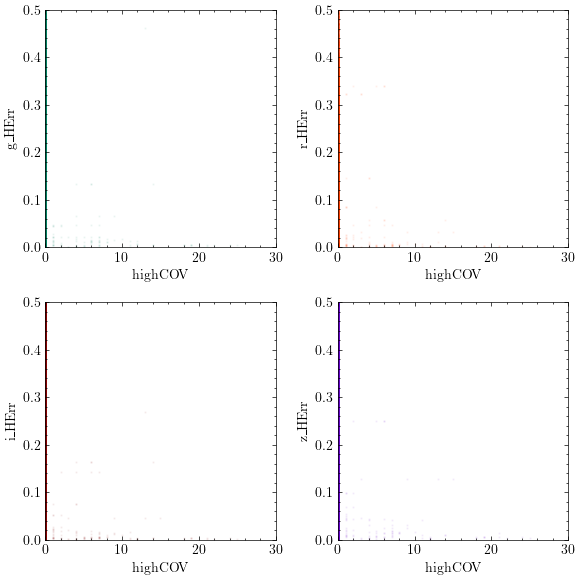

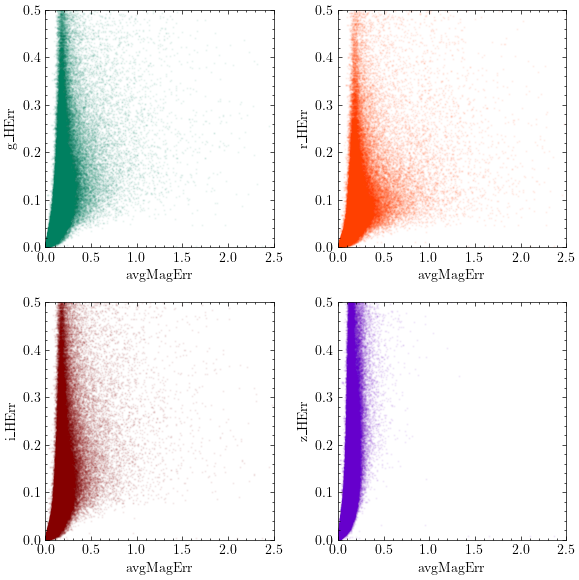

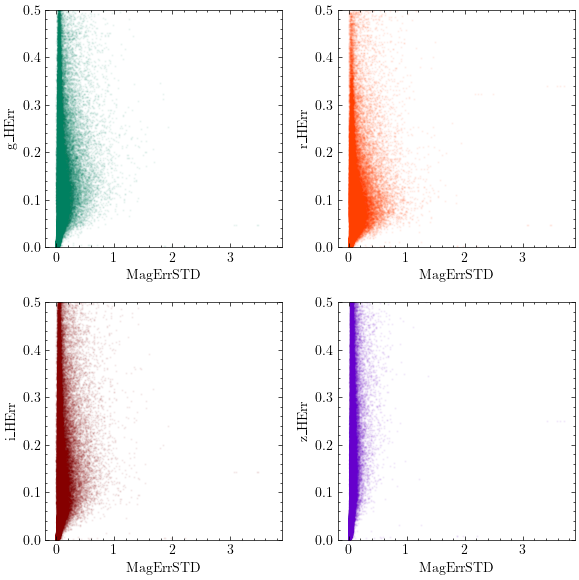

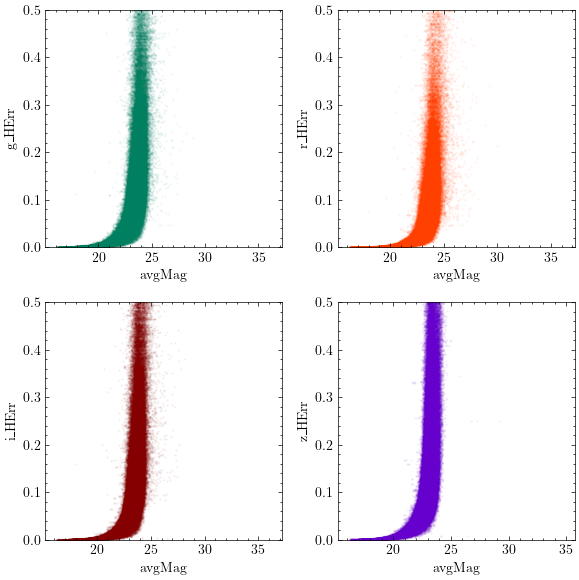

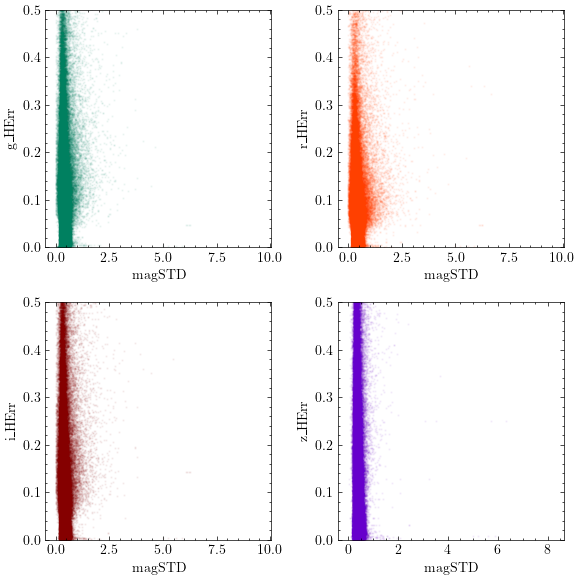

In [117]:
contrib_vars = ["minPhase", "maxPhase", "phaseDensity", "oppCOV", "modCOV", "highCOV","avgMagErr", "MagErrSTD", "avgMag", "magSTD"]

for var in contrib_vars:
    fig, axs = plt.subplots(2,2, figsize=(6,6))
    for filt, ax in zip(filters, axs.flatten()):
        
        ax.set_ylabel(f"{filt}_HErr")
        ax.set_xlabel(f"{var}")
        '''plt.ylim(0,1)'''
        ax.set_ylim(0,0.5)
        if var == "highCOV":
            ax.set_xlim(0,30)
            alpha = .5
        if var == "avgMagErr":
            ax.set_xlim(0,2.5)
            
        else:
            alpha = 0.05

        ax.scatter(
            df_merge_j[f"{var}"],
            df_merge_j[f"{filt}_HErr"],
            s=0.5,
            alpha=alpha,
            c=filter_colors[filt]
        )
        
    plt.tight_layout()
    plt.savefig(f"./phase_correlation_plots/{var}.png", dpi=300)

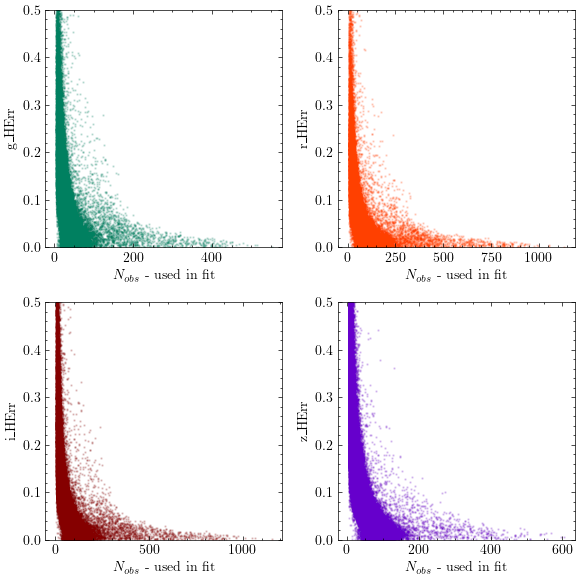

In [115]:

fig, axs = plt.subplots(2,2, figsize=(6,6))
for filt, ax in zip(filters, axs.flatten()):
    
    ax.set_ylabel(f"{filt}_HErr")
    ax.set_xlabel(r"$N_{obs}$ - used in fit")
    '''plt.ylim(0,1)'''
    ax.set_ylim(0,0.5)
    if var == "highCOV":
        ax.set_xlim(0,30)
        alpha = .5
    else:
        alpha = 0.05

    ax.scatter(
        df_merge_j[f"{filt}_Ndata"],
        df_merge_j[f"{filt}_HErr"],
        s=0.5,
        alpha=alpha,
        c=filter_colors[filt]
    )
    
plt.tight_layout()
plt.savefig("./phase_correlation_plots/Nobs.png", dpi=300)

Main belt

In [69]:
mb_ids = list(pd.read_csv("./IDS/Main Belt_ids.csv", index_col=False)["ssObjectId"])
#table = None
delta = 10000
for i in tqdm(range(np.floor(len(mb_ids)/delta).astype(int) + 1)): #tqdm(range(np.floor(len(trojan_ids)/delta).astype(int) + 1)):        
    stmt = f'''
        select sss.ssObjectId,
        band,
        count(phaseAngle), 
        min(phaseAngle) as minPhase, 
        max(phaseAngle) as maxPhase, 
        (max(phaseAngle) - min(phaseAngle))/count(sss.ssObjectId) as phaseDensity, 
        SUM(CASE WHEN phaseAngle < 2 THEN 1 ELSE 0 END) AS oppCOV, 
        SUM(CASE WHEN phaseAngle > 2 AND phaseAngle < 15 THEN 1 ELSE 0 END) AS modCOV, 
        SUM(CASE WHEN phaseAngle > 15 THEN 1 ELSE 0 END) AS highCOV,
        AVG(mag) as avgMag,
        STDDEV(mag) as magSTD,
        AVG(magErr) as avgMagErr,
        STDDEV(magErr) as MagErrSTD
        from dp03_catalogs_10yr.SSSource as sss
        left join dp03_catalogs_10yr.DiaSource as dia on sss.diaSourceId = dia.diaSourceId
        where sss.ssObjectId in {tuple(mb_ids[i*delta:(i+1)*delta])}
        group by sss.ssObjectId, band
        '''

    # mag, magErr, phaseAngle, band, heliocentricDist, topocentricDist, midPointMjdTai
    resp = query(stmt)
    if not table:
        table = resp.to_table()
    else:
        table = vstack([table, resp.to_table()])
    table.to_pandas().to_csv("./phase_parameters/main_belt.csv")
print("Got phase curve params")

 25%|██▍       | 105/428 [7:51:36<24:10:43, 269.49s/it]


KeyboardInterrupt: 

In [ ]:
photo_table = None
delta = 10000
for i in tqdm(range(np.floor(len(mb_ids)/delta).astype(int) + 1)):
    stmt = f'''
        select sso.ssObjectId,
        g_Chi2, g_G12, g_G12Err, g_H, g_HErr, g_Ndata, 
        i_Chi2, i_G12, i_G12Err, i_H, i_HErr, i_Ndata, 
        r_Chi2, r_G12, r_G12Err, r_H, r_HErr, r_Ndata, 
        z_Chi2, z_G12, z_G12Err, z_H, z_HErr, z_Ndata
        from dp03_catalogs_10yr.SSObject as sso
        where sso.ssObjectId in {tuple(mb_ids[i*delta:(i+1)*delta])}
        '''
    resp = query(stmt)
    if not photo_table:
        photo_table = resp.to_table()
    else:
        photo_table = vstack([photo_table, resp.to_table()])
    photo_table.to_pandas().to_csv("./photometric/main_belt.csv")

Main Belt asteroids

In [71]:
df_mb = pd.read_csv("./phase_parameters/main_belt.csv", index_col=False)
df_photo_mb = pd.read_csv("./photometric/main_belt.csv", index_col=False)
df_merge_mb = pd.merge(left=df_mb, right= df_photo_mb, on="ssObjectId")

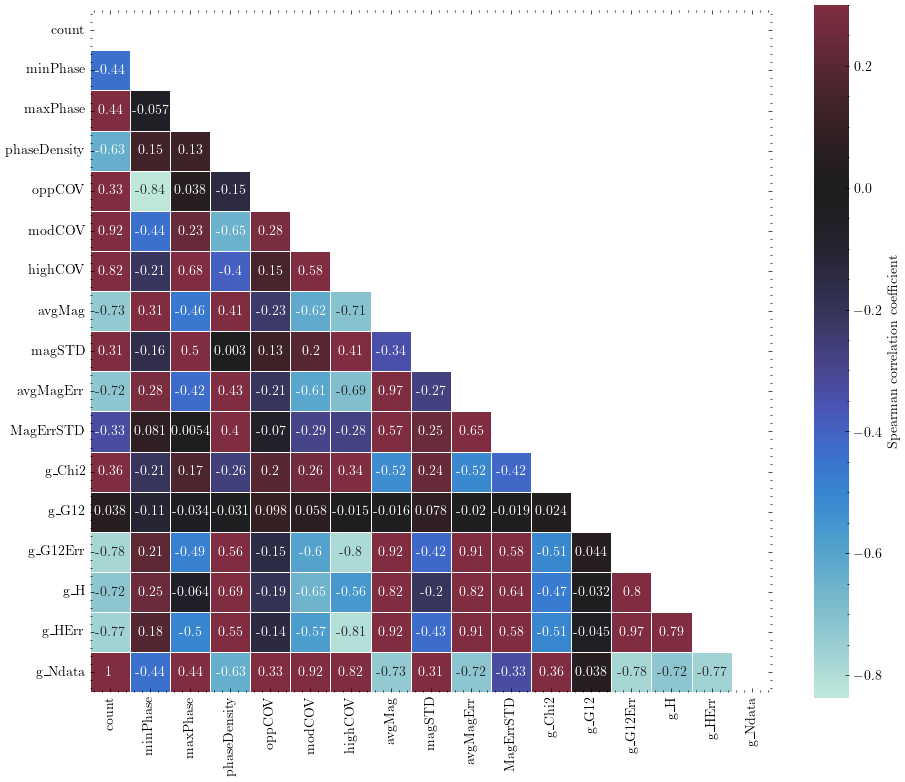

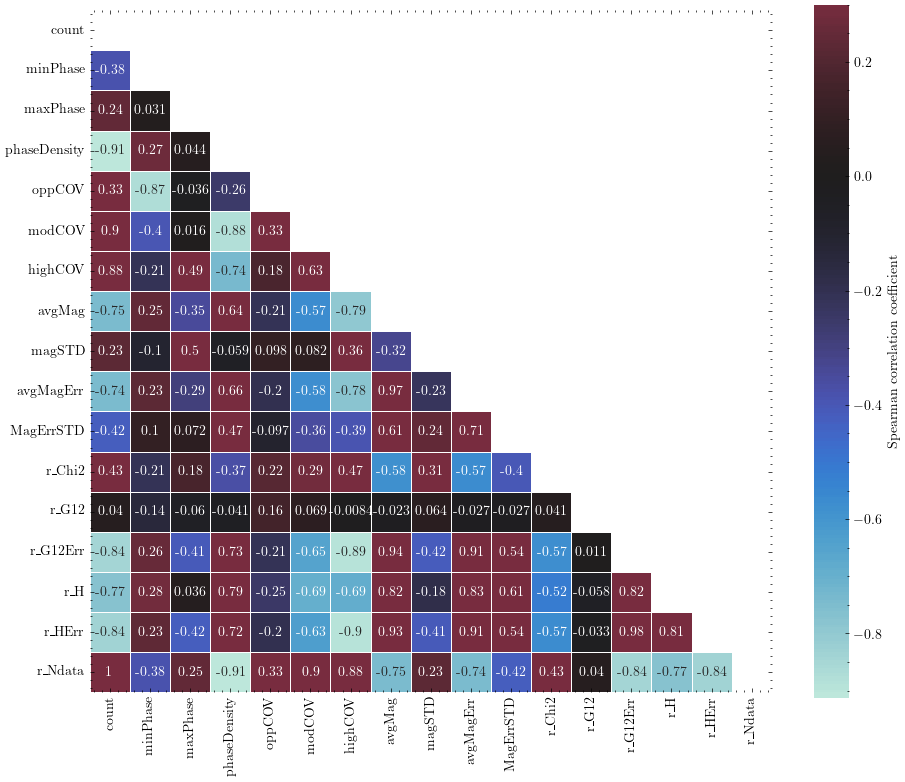

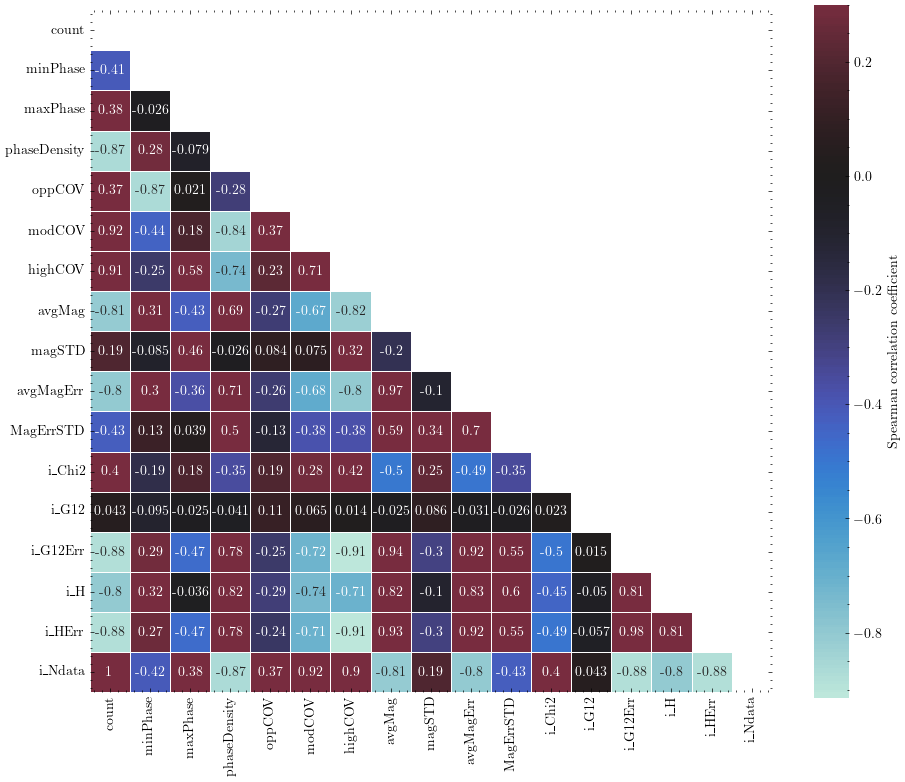

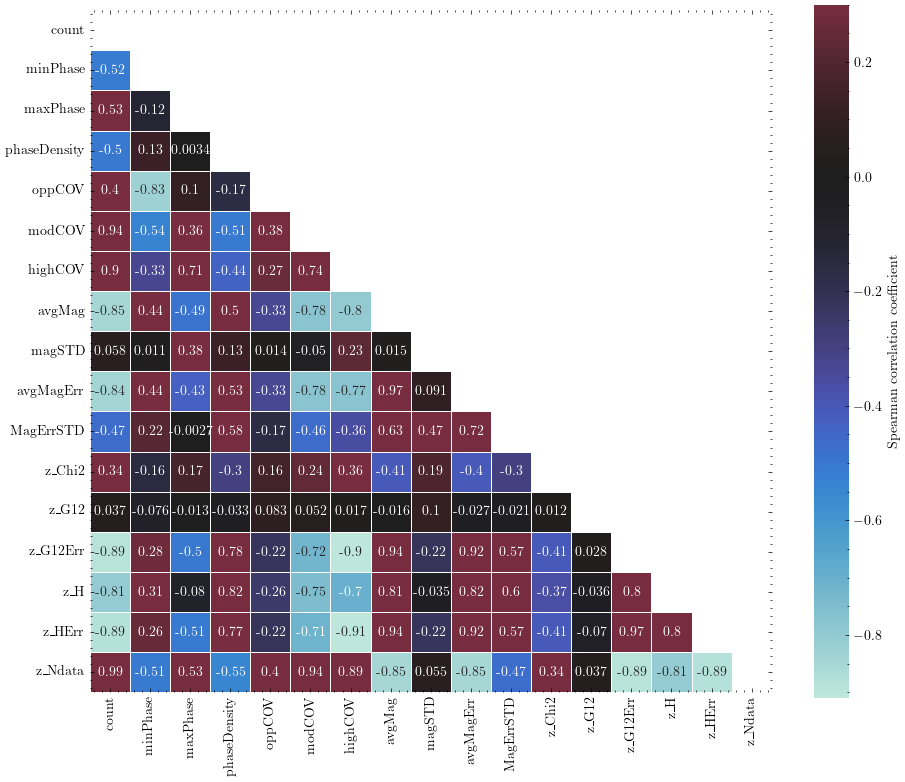

In [73]:
for filt in filters:
    corr = df_merge_mb[df_merge_mb["band"] == filt][['count', 'minPhase', 'maxPhase',
       'phaseDensity', 'oppCOV', 'modCOV', 'highCOV', 'avgMag', 'magSTD',
       'avgMagErr', 'MagErrSTD']+[f"{filt}_{attrib}" for attrib in attribs]].corr(method="spearman")
        
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, vmax=.3, center=0,
                square=True, linewidths=.5,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                annot=True,
                cbar_kws={'label': 'Spearman correlation coefficient'})

In [76]:
f.savefig("./corr_matrices/z_mb.png", dpi=300)